## <center>Sberbank NLP Notebook</center>

#### Задача: 
<i>Обучить интерпретируемую NLP модель на массиве размеченных данных таким образом, чтобы точность предсказаний на тестовой выборке была максимальной (оптимизационная задача)</i>

#### План: 
<i>
1. Выбор датасета
2. Предобработка данных
3. Feature Engineering 
4. Обучение моделей
5. Результаты и выводы </i>

In [1]:
import pandas as pd 
import logging

# info logging setup 
logging.basicConfig(level=logging.INFO, format='%(asctime)s : %(levelname)s : %(message)s')

# set ipython's max column, row display
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)

/home/greg/anaconda3/envs/py36_2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/greg/anaconda3/envs/py36_2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### 1. Выбор датасета 

В исследовании будет использован датасет Gender Classifier Data от Figure Eight (https://www.figure-eight.com/wp-content/uploads/2016/03/gender-classifier-DFE-791531.csv), содержащий 20050 объектов - пользователей Twitter - и предварительно размеченный вручную тремя экспертами на предмет пола каждого пользователя. 
Он же доступен на Kaggle (https://www.kaggle.com/crowdflower/twitter-user-gender-classification/home) с описаниями характеристик объектов: 

<b>_unit_id</b>: a unique id for user
<br><b>_golden</b>: whether the user was included in the gold standard for the model; TRUE or FALSE
<br><b>_unit_state</b>: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
<br><b>_trusted_judgments</b>: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
<br><b>_last_judgment_at</b>: date and time of last contributor judgment; blank for gold standard observations
<br><b>gender</b>: one of male, female, or brand (for non-human profiles)
<br><b>gender:confidence</b>: a float representing confidence in the provided gender
<br><b>profile_yn</b>: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
<br><b>profile_yn:confidence</b>: confidence in the existence/non-existence of the profile
<br><b>created</b>: date and time when the profile was created
<br><b>description</b>: the user's profile description
<br><b>fav_number</b>: number of tweets the user has favorited
<br><b>gender_gold</b>: if the profile is golden, what is the gender?
<br><b>link_color</b>: the link color on the profile, as a hex value
<br><b>name</b>: the user's name
<br><b>profile_yn_gold</b>: whether the profile y/n value is golden
<br><b>profileimage</b>: a link to the profile image
<br><b>retweet_count</b>: number of times the user has retweeted (or possibly, been retweeted)
<br><b>sidebar_color</b>: color of the profile sidebar, as a hex value
<br><b>text</b>: text of a random one of the user's tweets
<br><b>tweet_coord</b>: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
<br><b>tweet_count</b>: number of tweets that the user has posted
<br><b>tweet_created</b>: when the random tweet (in the text column) was created
<br><b>tweet_id</b>: the tweet id of the random tweet
<br><b>tweet_location</b>: location of the tweet; seems to not be particularly normalized
<br><b>user_timezone</b>: the timezone of the user

В рамках этого исследования будет производиться анализ только текстовой информации (текст случайного твита пользователя <b>text</b> и описание в его профиле <b>description</b>. Другие фичи в качестве надстройки над NLP не учавствуют. 

### 2. Предобработка данных

In [2]:
# импорт csv файла в датафрейм 
# https://www.figure-eight.com/wp-content/uploads/2016/03/ --перед файлом в след. строке чтобы не качать отдельно 
df_raw = pd.read_csv("gender-classifier-DFE-791531.csv", encoding="ISO-8859-1")
df_raw

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0000,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0000,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0000,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0000,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0000,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
5,815719231,False,finalized,3,10/27/15 1:47,female,1.0000,yes,1.0000,3/11/10 18:14,you don't know me.,3901,NaN,F5ABB5,monroevicious,NaN,https://pbs.twimg.com/profile_images/656336865...,0,0,"Ive seen people on the train with lamps, chair...",NaN,20036,10/26/15 12:40,6.587300e+17,New York Gritty,Central Time (US & Canada)
6,815719232,False,finalized,3,10/27/15 1:57,brand,1.0000,yes,1.0000,4/24/08 13:03,"A global marketplace for images, videos and mu...",4122,NaN,298AAE,Shutterstock,NaN,https://pbs.twimg.com/profile_images/528547133...,0,0,@BpackEngineer Thank you for your patience whi...,NaN,13354,10/26/15 12:40,6.587300e+17,Worldwide,Eastern Time (US & Canada)
7,815719233,False,finalized,3,10/26/15 23:48,male,1.0000,yes,1.0000,12/3/12 21:54,The secret of getting ahead is getting started.,80,NaN,0000FF,RobinMeske,NaN,https://pbs.twimg.com/profile_images/508875440...,0,C0DEED,Gala Bingo clubs bought for å£241m: The UK's l...,NaN,112117,10/26/15 12:40,6.587300e+17,NaN,NaN
8,815719234,False,finalized,3,10/27/15 1:52,female,1.0000,yes,1.0000,9/8/15 4:50,Pll Fan // Crazy about MCD // Ramen is bae,1825,NaN,9266CC,pigzilla_,NaN,https://pbs.twimg.com/profile_images/658670112...,0,0,@_Aphmau_ the pic defines all mcd fangirls/fan...,NaN,482,10/26/15 12:40,6.587300e+17,NaN,NaN
9,815719235,False,finalized,3,10/27/15 1:49,female,1.0000,yes,1.0000,5/13/11 3:32,"Renaissance art historian, University of Notti...",3115,NaN,9266CC,GabrieleNeher,NaN,https://pbs.twimg.com/profile_images/513327289...,0,FFFFFF,@Evielady just how lovely is the tree this yea...,NaN,26085,10/26/15 12:40,6.587300e+17,"Nottingham, England.",Amsterdam


In [3]:
"""
Из сырой выборки оставляем только объкты, где пол пользователя известен наверняка, профайл точно существует 
Избавляемся от всех параметров кроме текстов и меток классов: text, description, gender
Отбрасываем объекты с пропущенными значениями
"""

df = df_raw.loc[(df_raw['gender:confidence'] == 1.0) & (df_raw['profile_yn'] == 'yes') & (df_raw['profile_yn:confidence'] == 1.0)][['gender', 'text', 'description']].dropna()
df

,gender,text,description
0,male,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.
1,male,ÛÏIt felt like they were my friends and I was...,I'm the author of novels filled with family dr...
3,male,Hi @JordanSpieth - Looking at the url - do you...,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe..."
4,female,Watching Neighbours on Sky+ catching up with t...,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...
5,female,"Ive seen people on the train with lamps, chair...",you don't know me.
6,brand,@BpackEngineer Thank you for your patience whi...,"A global marketplace for images, videos and mu..."
7,male,Gala Bingo clubs bought for å£241m: The UK's l...,The secret of getting ahead is getting started.
8,female,@_Aphmau_ the pic defines all mcd fangirls/fan...,Pll Fan // Crazy about MCD // Ramen is bae
9,female,@Evielady just how lovely is the tree this yea...,"Renaissance art historian, University of Notti..."
11,brand,MTG Deals 1x Rank-Up-Magic - The Seventh One -...,highly extraordinary auctions


In [4]:
df.gender.unique()

array(['male', 'female', 'brand', 'unknown'], dtype=object)

In [5]:
# оставляем только муж/жен
df = df.loc[~df['gender'].isin(['unknown', 'brand'])]
df.gender.unique()

array(['male', 'female'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8766 entries, 0 to 20049
Data columns (total 3 columns):
gender         8766 non-null object
text           8766 non-null object
description    8766 non-null object
dtypes: object(3)
memory usage: 273.9+ KB


In [7]:
df.describe()

,gender,text,description
count,8766,8766,8766
unique,2,8727,8454
top,female,"Build a Transforming Workbench, Desk, and Stor...",'Cos even an old girl's best friend is still h...
freq,4616,11,18


In [8]:
# балансировка классов в целом ок
class_balance = df.groupby('gender').count()
class_balance

,text,description
gender,,
female,4616,4616
male,4150,4150


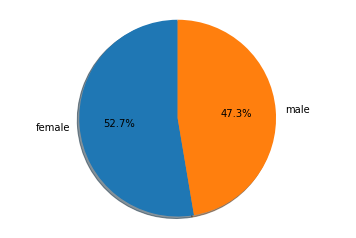

In [9]:
# (pie chart) визуализация балансировки классов 
import matplotlib.pyplot as plt
%matplotlib inline  

labels = list(class_balance.index.values)
sizes = class_balance.text

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [10]:
# объединение фичей text и description в один документ 
df = df.assign(text = df['text'].map(str) + df['description'])
df = df.drop(['description'], axis=1).reset_index(drop=True)
df

,gender,text
0,male,Robbie E Responds To Critics After Win Against...
1,male,ÛÏIt felt like they were my friends and I was...
2,male,Hi @JordanSpieth - Looking at the url - do you...
3,female,Watching Neighbours on Sky+ catching up with t...
4,female,"Ive seen people on the train with lamps, chair..."
5,male,Gala Bingo clubs bought for å£241m: The UK's l...
6,female,@_Aphmau_ the pic defines all mcd fangirls/fan...
7,female,@Evielady just how lovely is the tree this yea...
8,female,@giannaaa28 lmao _Ù÷â_Ù÷â dude I'm hella scare...
9,male,@coolyazzy94 Ditto - I'm still learning the fa...


In [11]:
# X и y для test_train_split

from joblib import Parallel, delayed
import numpy as np
import gensim

def tokenize_text(i):
    # convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long
    return gensim.utils.simple_preprocess(str(df.iloc[i]['text']), deacc=True)

X = np.array([Parallel(n_jobs=4)(delayed(tokenize_text)(i) for i in range(df.shape[0]))]).reshape((df.shape[0]))
y = np.array([(lambda i: df.iloc[i]['gender'])(i)for i in range(df.shape[0])])

2018-08-22 00:59:31,107 : INFO : 'pattern' package not found; tag filters are not available for English


In [12]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# лейблы вместо текста для целевой переменной 
enc = preprocessing.LabelEncoder()
y = enc.fit_transform(y)
# TODO: не забыть сделать inverse_transform: enc.inverse_transform(y)

# Тестовая и контрольная выборки, random_state for reproducible research 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# ---конец предобработки--- #

In [13]:
enc_mapping = dict(zip(enc.classes_, enc.transform(enc.classes_)))

### 3. Feature Engineering 

Теперь необходимо привести текст каждого объекта к векторной (матричной) форме. 

<br>Найдем векторы слов Word2vec для каждого объекта и найдем их среднее арифметическое учитывая веса TF-IDF.

TF-IDF: https://ru.wikipedia.org/wiki/TF-IDF (сравнительно простая модель, частота слова из документа вычисляется прямопропорционально числу вхождения слова в этот документ и обратнопропорционально числу вхождения слова в corpus (все док-ты коллекции). 
<br><br>Word2Vec: https://ru.wikipedia.org/wiki/Word2vec (учитывает окружение слова, хотя порядок слов в окружении алгоритм не учитывает) 

In [14]:
# TFIDF - веса слов 

from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction import text

'''
Препроцессинг прошел не идеально: есть части языковых конструкций (ll - will, don - don't и т.д.),
часто употребляемые прилагательные (размер, восклицание и т.д.),
синонимы (ig - instagram и т.д.) и так далее. Список стоп слов был частично расширен вручную так, 
чтобы нерелевантные не лезли в топ25
'''

stop_words = ["just", "like", "don", "https", "best", "want", "know", "good", "ve", "a_u", "make", "got", "new", "ªa", "need", "im", "http", "think", "ll", "need", "u_", "say", "com", "great", "really", "shit", "say", "going", "little", "right", "follow", "let", "today", "thank", "live", "things", "god", "come", "year", "way", "day", "love", "life", "wanna", "big", "free", "big", "better", "look", "gonna", "makes", "time", "fuck", "tweets", "amp", "lover", "lot", "real", "instagram", "thanks", "thing", "did", "old", "people", "trying", "ii"]
stop_words_extended = text.ENGLISH_STOP_WORDS.union(stop_words)

def dummy(doc_text):
    return doc_text

# word level tf-idf
tfidf_mod = TfidfVectorizer(
    analyzer='word', 
    strip_accents='unicode',
    norm="l2", # евклидова норма=1
    #ngram_range=(1, 2), # unigrams + bigrams
    sublinear_tf=True, 
    tokenizer=dummy, 
    preprocessor=dummy,
    stop_words=stop_words_extended)

tfidf_mod.fit(X)

X_tfidf = tfidf_mod.transform(X)

# Sparse tf-idf-weighted document-term matrix [n_samples, n_features]

#xtrain_tfidf, xtest_tfidf = tfidf_mod.transform(X_train), tfidf_mod.transform(X_test) 
X_tfidf = tfidf_mod.transform(X)

# convert to dense 
tfidf_index_value = {i[1]:i[0] for i in tfidf_mod.vocabulary_.items()}

def sparse_to_dense(sparse):
    dense = []
    for row in sparse:
        dense.append({tfidf_index_value[col]:val for (col,val) in zip(row.indices,row.data)})
    return dense
    
#xtrain_tfidf_dense, xtest_tfidf_dense = sparse_to_dense(xtrain_tfidf), sparse_to_dense(xtest_tfidf)
x_tfidf_dense = sparse_to_dense(X_tfidf)
features = tfidf_mod.get_feature_names()

/home/greg/anaconda3/envs/py36_2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/greg/anaconda3/envs/py36_2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


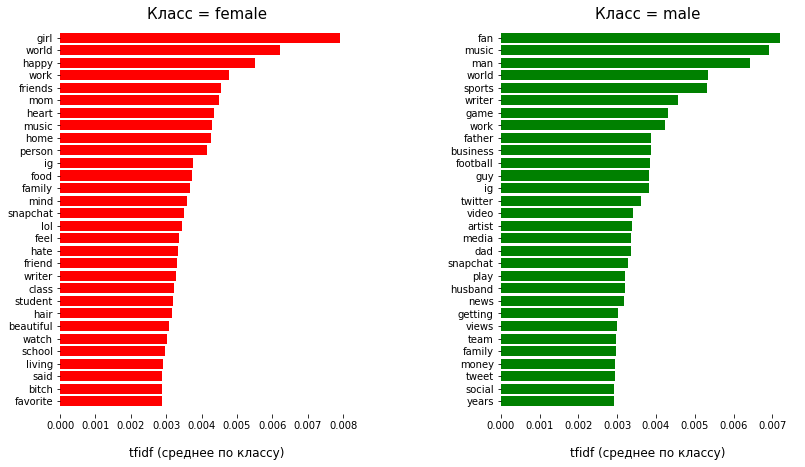

In [15]:
# top words per gender 

def top_tfidf(row_id, feats, top_n=10):
    ''' Возвращает top_n=10 слов в порядке убывания их tfidf scores '''
    top_ids = np.argsort(row_id)[::-1][:top_n]
    top_feats = [(feats[i], row_id[i]) for i in top_ids]
    top_tfidf_df = pd.DataFrame(top_feats)
    top_tfidf_df.columns = ['feature', 'tfidf_score']
    top_tfidf_df.sort_values('tfidf_score', inplace=True)
    return top_tfidf_df

def top_feats_in_doc(X, feats, row, top_n=10):
    ''' Возвращает top_n=10 фичей в документе (строка матрицы) '''
    row = np.squeeze(X[row].toarray())
    return top_tfidf_feats(row, feats, top_n)

def top_mean_feats(X, feats, X_row_ids=None, min_tfidf=0.1, top_n=10):
    ''' Возвращает top_n самых важных фичей из строк X_row_ids '''
    if X_row_ids:
        X_ = X[X_row_ids].toarray()
    else:
        X_ = X.toarray()

    X_[X_ < min_tfidf] = 0
    tfidf_means = np.mean(X_, axis=0)
    return top_tfidf(tfidf_means, feats, top_n)

def top_feats_by_label(X, y, feats, min_tfidf=0.1, top_n=10):
    ''' Возвращает список датафреймов с top_n для каждого из лейблов из y '''
    dfs = {} # dict для датафреймов, ключами станут лейблы 
    lbls = np.unique(y) # все лейблы целевой переменной 
    for label in lbls:
        ids = np.where(y==label) # идентификаторы нужных строк для текущего лейбла 
        feats_df = top_mean_feats(X, feats, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs

def plot_top_feats_by_label(dfs):
    ''' Строит лежачие столбчатые диаграммы по датафреймам от top_feats_by_label '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    colors = ['r', 'g', 'y', 'b']
    for i, df in dfs.items():
        ax = fig.add_subplot(1, len(dfs), i+1)
        
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("tfidf (среднее по классу)", labelpad=16, fontsize=12, color="k")
        ax.set_title("Класс = " + str(enc.inverse_transform(df.label)), fontsize=15)
        ax.ticklabel_format(axis='x', style='plain', scilimits=(-2,2))
        ax.barh(x, df.tfidf_score, align='center', color=colors[i])
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.1, right=1, left=0.15, top=0.7, wspace=0.5)
    plt.show()
    
plot_top_feats_by_label(top_feats_by_label(X_tfidf, y, features, top_n=30))

In [16]:
# Word2Vec

# обучаем словарь Word2Vec на коллекции документов, каждое слово теперь представлено в виде вектора 
# size => кол-во возможных значений gender
w2v_mod = gensim.models.Word2Vec(X, workers=4, min_count=1)

'''bigram_model = Phrases(unigram_sentences)

for unigram_sentence in unigram_sentences:                
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            
# gensim for bigrams | TODO: сделать и подружить с tfidf биграммами если останется время 
''' 


2018-08-22 00:59:40,624 : INFO : collecting all words and their counts
2018-08-22 00:59:40,625 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-22 00:59:40,681 : INFO : collected 37694 word types from a corpus of 236963 raw words and 8766 sentences
2018-08-22 00:59:40,682 : INFO : Loading a fresh vocabulary
2018-08-22 00:59:40,835 : INFO : effective_min_count=1 retains 37694 unique words (100% of original 37694, drops 0)
2018-08-22 00:59:40,836 : INFO : effective_min_count=1 leaves 236963 word corpus (100% of original 236963, drops 0)
2018-08-22 00:59:40,955 : INFO : deleting the raw counts dictionary of 37694 items
2018-08-22 00:59:40,957 : INFO : sample=0.001 downsamples 36 most-common words
2018-08-22 00:59:40,957 : INFO : downsampling leaves estimated 197473 word corpus (83.3% of prior 236963)
2018-08-22 00:59:41,088 : INFO : estimated required memory for 37694 words and 100 dimensions: 49002200 bytes
2018-08-22 00:59:41,089 : INFO : resetting laye

"bigram_model = Phrases(unigram_sentences)\n\nfor unigram_sentence in unigram_sentences:                \n            bigram_sentence = u' '.join(bigram_model[unigram_sentence])\n            \n# gensim for bigrams | TODO: сделать и подружить с tfidf биграммами если останется время \n"

In [17]:
# Теперь, имея в распоряжении веса TFIDF и соответствующие векторные формы слов от gensim, 
# вычисляем репрезентативный вектор для каждого объекта обучающей и тестовой выборок 

def w2v_weighted(corpus):
    w2v_w = []
    for doc in corpus:
        weighted_terms = []
        for key, value in doc.items():
            weighted_term = w2v_mod.wv[key] * (2. + value)
            weighted_terms.append(weighted_term)
        weighted_mean = np.array((weighted_terms)).mean(axis=0)
        w2v_w.append(weighted_mean)
    return w2v_w
    
            
            
#xtrain_w2v, xtest_w2v = w2v_weighted(xtrain_tfidf_dense), w2v_weighted(xtest_tfidf_dense)
X_w2v = w2v_weighted(x_tfidf_dense)
X_w2v[0]

array([-1.85163572e-01, -1.99612215e-01,  5.21929227e-02,  2.30720967e-01,
       -2.01317251e-01, -5.76203912e-02, -1.27385959e-01,  1.76778913e-01,
        2.16381326e-01,  2.64665544e-01, -1.35249689e-01, -1.40592948e-01,
       -1.85972512e-01, -1.05314642e-01,  2.65555769e-01, -8.83417055e-02,
        6.21872693e-02,  1.20750003e-01, -2.98137460e-02, -3.16141307e-01,
        2.34856054e-01, -5.08725829e-02, -2.37353425e-02, -4.15505655e-03,
        2.37915125e-02,  6.63894694e-03,  1.76924437e-01, -2.86931787e-02,
       -1.58861041e-01, -9.13413316e-02, -9.76278167e-03,  1.27898213e-02,
       -8.93375557e-03,  9.00951698e-02, -1.43086001e-01,  1.16524644e-01,
        1.04988270e-01, -1.62401441e-02, -1.48800448e-01,  4.41297516e-02,
       -7.85508193e-03, -1.60340250e-01,  3.11304897e-01, -8.12501833e-02,
        8.30157921e-02,  1.64610222e-02, -6.40242621e-02,  9.42668170e-02,
        3.64863127e-02,  2.12050006e-01, -2.66968235e-02, -1.68449447e-01,
        1.71488170e-02, -

In [18]:
# вместо нормализации вписываем в [0, 1] для SVM (отрицательные не принимает)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_w2v)
#xtrain_w2v_sc = scaler.transform(xtrain_w2v)
#xtest_w2v_sc = scaler.transform(xtest_w2v)
X_w2v_sc = scaler.transform(X_w2v)
X_w2v_sc

array([[0.93708627, 0.93803562, 0.05881538, ..., 0.85297372, 0.04527353,
        0.91333771],
       [0.79530248, 0.79133603, 0.17660449, ..., 0.78581035, 0.12996637,
        0.75089328],
       [0.87453538, 0.87318965, 0.11309764, ..., 0.82525396, 0.10412869,
        0.8507637 ],
       ...,
       [0.88259862, 0.88056569, 0.11036286, ..., 0.81437241, 0.12319779,
        0.87760244],
       [0.77608917, 0.77516804, 0.21185188, ..., 0.70240319, 0.21478214,
        0.78004294],
       [0.70698742, 0.70387103, 0.27902183, ..., 0.67272949, 0.25225925,
        0.6856693 ]])

/home/greg/anaconda3/envs/py36_2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


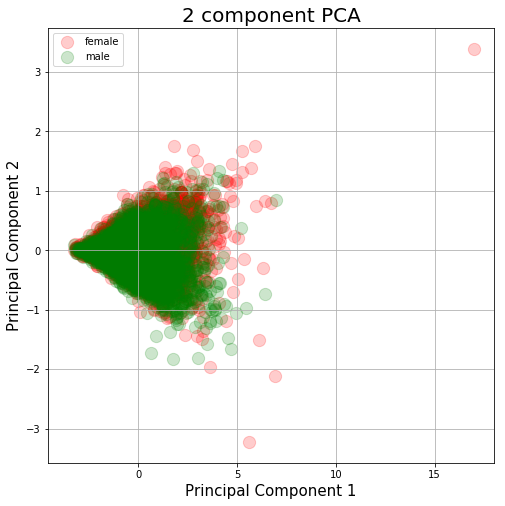

In [19]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_w2v)
principalDf = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2'])
finalDf = pd.concat([principalDf, pd.DataFrame(y, columns=['target'])], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 150, alpha=0.2)
ax.legend(enc.inverse_transform(targets))
ax.grid()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8766 samples in 0.033s...
[t-SNE] Computed neighbors for 8766 samples in 1.939s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8766
[t-SNE] Computed conditional probabilities for sample 2000 / 8766
[t-SNE] Computed conditional probabilities for sample 3000 / 8766
[t-SNE] Computed conditional probabilities for sample 4000 / 8766
[t-SNE] Computed conditional probabilities for sample 5000 / 8766
[t-SNE] Computed conditional probabilities for sample 6000 / 8766
[t-SNE] Computed conditional probabilities for sample 7000 / 8766
[t-SNE] Computed conditional probabilities for sample 8000 / 8766
[t-SNE] Computed conditional probabilities for sample 8766 / 8766
[t-SNE] Mean sigma: 0.052000
[t-SNE] Computed conditional probabilities in 0.498s
[t-SNE] Iteration 50: error = 93.9269867, gradient norm = 0.0268323 (50 iterations in 11.658s)
[t-SNE] Iteration 100: error = 77.1268082, gradient norm = 0.0041607 (50 iterations in 1

/home/greg/anaconda3/envs/py36_2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


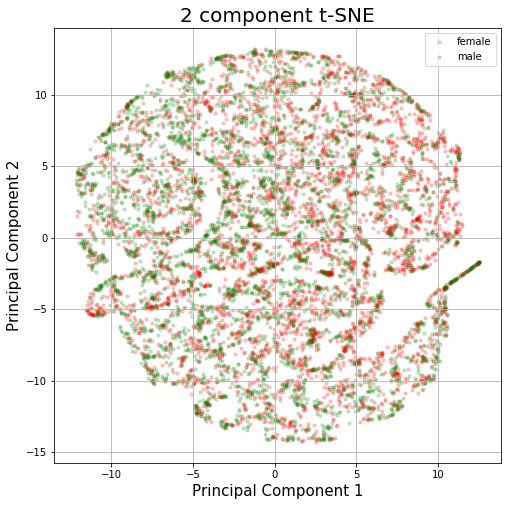

In [20]:
# TSNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=2, n_iter=300)
principalComponents = tsne.fit_transform(X_w2v)

principalDf = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2'])
finalDf = pd.concat([principalDf, pd.DataFrame(y, columns=['target'])], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10, alpha=0.2)
ax.legend(enc.inverse_transform(targets))
ax.grid()

Классы разделимы довольно плохо, скорее всего сказывается сравнительно малый размер данных

### 4. Модели

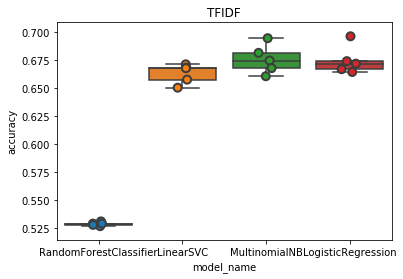

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.530787
1,RandomForestClassifier,1,0.528808
2,RandomForestClassifier,2,0.526526
3,RandomForestClassifier,3,0.528808
4,RandomForestClassifier,4,0.527667
5,LinearSVC,0,0.650513
6,LinearSVC,1,0.671420
7,LinearSVC,2,0.657730
8,LinearSVC,3,0.668568
9,LinearSVC,4,0.667998


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

def models_accuracy(X, y, data_eng_method):
    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        LinearSVC(random_state=0),
        MultinomialNB(),
        LogisticRegression(random_state=0)]

    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.title(data_eng_method)
    plt.show()
    
    return cv_df
              
models_accuracy(X_tfidf, y, "TFIDF")

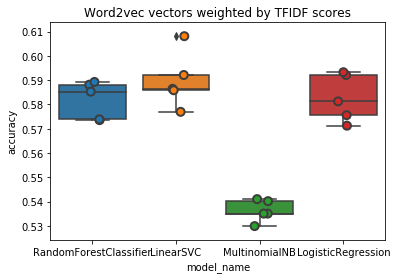

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.573546
1,RandomForestClassifier,1,0.588135
2,RandomForestClassifier,2,0.573873
3,RandomForestClassifier,3,0.585282
4,RandomForestClassifier,4,0.589276
5,LinearSVC,0,0.576967
6,LinearSVC,1,0.586423
7,LinearSVC,2,0.592128
8,LinearSVC,3,0.585853
9,LinearSVC,4,0.608100


In [26]:
models_accuracy(X_w2v_sc, y, "Word2vec vectors weighted by TFIDF scores")

In [23]:
# настроить регуляризатор для w2v_weighted
# добавить pipeline с gridsearchcv 